In [1]:
import pandas as pd
import torch

# from pytorchtools import EarlyStopping

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
# from influxdb_client import InfluxDBClient, Point, WritePrecision
# from influxdb_client.client.write_api import SYNCHRONOUS
# import bamboolib as bam
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy.fftpack import fft, ifft
from scipy import signal
import os
import datetime
import time
from numpy import sign
from sklearn.cluster import KMeans
from scipy import pi
import plotly.express as px
from datetime import datetime


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from scipy.fftpack import fft, ifft
from scipy import signal
import os
import datetime
import time
from numpy import sign
from sklearn.cluster import KMeans
from scipy import pi
import plotly.express as px

In [3]:
import numpy as np

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
batch_size = 15
lr_rate = 1e-5
patience = 10
epochs = 800
used_feature = ['spindle_speed', 'ap', 'fz', 'vbs', 'clamp_t1',
       'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6', 'clamp_t7',
       'clamp_t8', 'robot_t1', 'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5',
       'robot_t6', 'robot_t7', 'robot_t8', 'clamp_f1', 'clamp_f2', 'clamp_f3',
       'clamp_f4', 'clamp_f5', 'clamp_f6', 'clamp_f7', 'clamp_f8', 'clamp_f9',
       'clamp_f10', 'clamp_f11', 'clamp_f12', 'robot_f1', 'robot_f2',
       'robot_f3', 'robot_f4', 'robot_f5', 'robot_f6', 'robot_f7', 'robot_f8',
       'robot_f9', 'robot_f10', 'robot_f11', 'robot_f12']

In [5]:
up_or_down = 'up' # or down
all_data = pd.read_csv('./train_{}_YY.csv'.format(up_or_down))
all_data.drop(index=[71,91,48,53,72],axis=0,inplace=True)
all_data.head()

,Nr.,spindle_speed,ap,fz,Ra_up,vbs,clamp_t1,clamp_t2,clamp_t3,clamp_t4,...,robot_f3,robot_f4,robot_f5,robot_f6,robot_f7,robot_f8,robot_f9,robot_f10,robot_f11,robot_f12
0,1,8000,0.2,0.050,12.90500,800,26.229323,35.996803,44.484558,0.123780,...,27.195928,38.454851,0.707217,41.489773,1.834573,2.750153,0.215668,5.045701,51.978762,5.050505
1,2,8000,0.2,0.065,6.78175,1040,29.329545,31.538638,43.024878,0.380916,...,28.010454,39.087481,0.716609,48.062763,2.059287,2.442525,0.162410,6.069366,45.485476,4.545455
2,3,8000,0.2,0.075,8.43450,1200,22.787313,38.788434,44.924273,0.123561,...,27.192374,38.362475,0.708827,48.174787,2.140555,2.318279,0.158031,6.145418,63.985078,5.050505
3,4,8000,0.2,0.100,6.77025,1600,28.397163,46.030452,54.015627,-0.147312,...,27.991056,39.301907,0.712206,54.038531,2.316717,2.182508,0.132116,7.249209,84.466924,5.050505
4,5,8000,0.4,0.050,12.54250,800,43.666667,28.707179,52.226146,0.457839,...,28.030627,38.133353,0.735069,33.375292,1.394820,3.848968,0.316728,4.060900,32.618295,6.060606


In [6]:
all_data.columns

Index(['Nr.', 'spindle_speed', 'ap', 'fz', 'Ra_up', 'vbs', 'clamp_t1',
       'clamp_t2', 'clamp_t3', 'clamp_t4', 'clamp_t5', 'clamp_t6', 'clamp_t7',
       'clamp_t8', 'robot_t1', 'robot_t2', 'robot_t3', 'robot_t4', 'robot_t5',
       'robot_t6', 'robot_t7', 'robot_t8', 'clamp_f1', 'clamp_f2', 'clamp_f3',
       'clamp_f4', 'clamp_f5', 'clamp_f6', 'clamp_f7', 'clamp_f8', 'clamp_f9',
       'clamp_f10', 'clamp_f11', 'clamp_f12', 'robot_f1', 'robot_f2',
       'robot_f3', 'robot_f4', 'robot_f5', 'robot_f6', 'robot_f7', 'robot_f8',
       'robot_f9', 'robot_f10', 'robot_f11', 'robot_f12'],
      dtype='object')

In [7]:
#standardization
# for feature in used_feature:
#     mean = all_data[feature].mean()
#     std = all_data[feature].mean()
#     if std != 0:
#         all_data[feature] = all_data[feature].apply(lambda x: (x - mean) / std)
#     else:
#         print(feature)

In [8]:
from sklearn.model_selection import train_test_split

X = all_data[used_feature] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = all_data['Ra_{}'.format(up_or_down)]


x_train, x_test , y_train, y_test= train_test_split(X, Y,test_size = 0.2, random_state = 40, shuffle = True)

In [9]:
X

,spindle_speed,ap,fz,vbs,clamp_t1,clamp_t2,clamp_t3,clamp_t4,clamp_t5,clamp_t6,...,robot_f3,robot_f4,robot_f5,robot_f6,robot_f7,robot_f8,robot_f9,robot_f10,robot_f11,robot_f12
0,8000,0.2,0.050,800,26.229323,35.996803,44.484558,0.123780,-0.099902,3.484355,...,27.195928,38.454851,0.707217,41.489773,1.834573,2.750153,0.215668,5.045701,51.978762,5.050505
1,8000,0.2,0.065,1040,29.329545,31.538638,43.024878,0.380916,0.485154,2.975023,...,28.010454,39.087481,0.716609,48.062763,2.059287,2.442525,0.162410,6.069366,45.485476,4.545455
2,8000,0.2,0.075,1200,22.787313,38.788434,44.924273,0.123561,-0.156648,3.361212,...,27.192374,38.362475,0.708827,48.174787,2.140555,2.318279,0.158031,6.145418,63.985078,5.050505
3,8000,0.2,0.100,1600,28.397163,46.030452,54.015627,-0.147312,-0.012214,3.128724,...,27.991056,39.301907,0.712206,54.038531,2.316717,2.182508,0.132116,7.249209,84.466924,5.050505
4,8000,0.4,0.050,800,43.666667,28.707179,52.226146,0.457839,0.447397,2.412585,...,28.030627,38.133353,0.735069,33.375292,1.394820,3.848968,0.316728,4.060900,32.618295,6.060606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,16000,1.0,0.100,3200,9.865741,416.723605,415.874887,-0.130696,-1.029674,1.707244,...,30.735095,39.795877,0.772319,71.468094,2.671611,2.110433,0.077104,12.560238,84.996157,40.909091
100,16000,0.2,0.060,1920,25.111913,118.858056,121.271781,-0.001316,-1.365349,1.921304,...,32.362711,40.456815,0.799932,45.210775,1.563791,4.076264,0.182862,7.250659,72.977529,40.909091
101,16000,0.2,0.070,2240,30.383459,116.131722,119.829170,-0.013588,-1.435952,1.760840,...,31.749323,39.631053,0.801122,47.510061,1.674750,3.800691,0.161755,8.041105,78.270841,40.909091
102,16000,0.2,0.080,2560,31.652510,161.716911,164.478772,-0.081270,-1.388790,1.842183,...,30.550585,39.803982,0.767526,51.986447,1.963578,2.829154,0.139636,7.639984,63.748657,40.909091


In [10]:
from torch.utils.data import Dataset, DataLoader
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, df_train, df_label):
        # store the inputs and outputs
        self.X = torch.tensor(df_train.values).float()
        self.y = torch.tensor(df_label.values).float()
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [11]:
train_dl = DataLoader(CSVDataset(x_train, y_train), batch_size = batch_size, shuffle = True)
test_dl = DataLoader(CSVDataset(x_test, y_test), batch_size = 1024, shuffle = False)

In [12]:
len(used_feature)

44

In [13]:
from torch import nn
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(n_inputs, 32), # input layer
          nn.ReLU(),
          nn.Linear(32, 16), # 2nd
          nn.ReLU(),
          nn.Linear(16, 8), # 3rd
          nn.ReLU(),
          nn.Linear(8, 1) # final
        )
        
    # forward propagate input
    def forward(self, X):
        X = self.layers(X)
#         X = self.activation(X)
        return X

In [14]:
mlp_model = MLP(len(used_feature))

In [15]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr = lr_rate)  #lr=1e-4

In [16]:
best_test_loss = float('inf')
# Run the training loop
early_stopping = EarlyStopping(patience = patience, verbose=True)

avg_train_losses = []
avg_test_losses = []

for epoch in range(epochs): # 5 epochs at maximum
    test_losses = []
    train_losses = []
    # Print epoch
    print(f'Starting epoch {epoch + 1}')

    # Set current loss value
    mlp_model.train()
    
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dl, 0):
        # Get inputs
        inputs, targets = data
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs = mlp_model(inputs)

        # Compute loss
        loss = torch.sqrt(loss_function(outputs.flatten(), targets))

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
        # Print statistics
        train_losses.append(loss.item())
    
    
    
    mlp_model.eval()
    with torch.no_grad():
        
        for i, data in enumerate(test_dl, 0):
            # Get inputs
            inputs, targets = data
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            outputs = mlp_model(inputs)

            # Compute loss
            loss = torch.sqrt(loss_function(outputs.flatten(), targets))
            
            test_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    test_loss = np.average(test_losses)
    avg_train_losses.append(train_loss)
    avg_test_losses.append(test_loss)
    
    
    print(f'Epoch: {epoch+1:02}')
    print('-----------------')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest. Loss: {test_loss:.3f}')
        
    if test_loss < best_test_loss:
        print('Test loss decreased form {:.3f} to {:.3f}!'.format(best_test_loss, test_loss))
        best_test_loss = test_loss
        torch.save(mlp_model.state_dict(), 'best-model.pt')

        
    # early_stopping 
    early_stopping(test_loss, mlp_model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# Process is complete.
print('Training process has finished.')

Starting epoch 1
Epoch: 01
-----------------
	Train Loss: 17.071
	Test. Loss: 15.832
Test loss decreased form inf to 15.832!
Validation loss decreased (inf --> 15.832415).  Saving model ...
Starting epoch 2
Epoch: 02
-----------------
	Train Loss: 16.666
	Test. Loss: 15.247
Test loss decreased form 15.832 to 15.247!
Validation loss decreased (15.832415 --> 15.246881).  Saving model ...
Starting epoch 3
Epoch: 03
-----------------
	Train Loss: 15.004
	Test. Loss: 14.662
Test loss decreased form 15.247 to 14.662!
Validation loss decreased (15.246881 --> 14.662237).  Saving model ...
Starting epoch 4
Epoch: 04
-----------------
	Train Loss: 15.590
	Test. Loss: 14.083
Test loss decreased form 14.662 to 14.083!
Validation loss decreased (14.662237 --> 14.083059).  Saving model ...
Starting epoch 5
Epoch: 05
-----------------
	Train Loss: 15.087
	Test. Loss: 13.502
Test loss decreased form 14.083 to 13.502!
Validation loss decreased (14.083059 --> 13.501719).  Saving model ...
Starting epoch

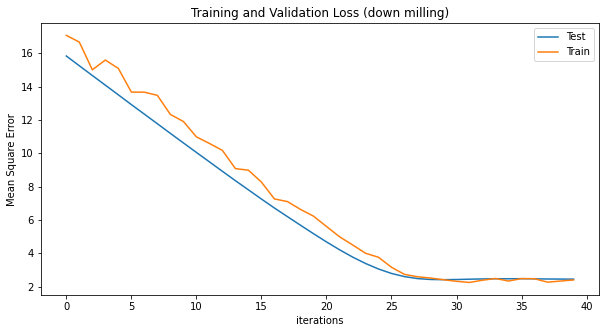

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize = (10,5))
plt.title("Training and Validation Loss (down milling)")
plt.plot(avg_test_losses,label = "Test")
plt.plot(avg_train_losses,label = "Train")
plt.xlabel("iterations")
plt.ylabel("Mean Square Error")
plt.legend()
plt.savefig('loss_all_data(up).png')
plt.show()

In [18]:
# load best model
mlp_model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [19]:
mlp_model.eval()
train_real = []
train_predict = []
for i, data in enumerate(train_dl, 0):
    # Get inputs
    inputs, targets = data
    outputs = mlp_model(inputs)
    train_real.extend(targets.tolist())
    train_predict.extend(outputs.flatten().tolist())

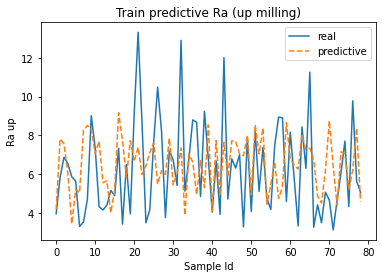

In [20]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(train_real)), train_real, label = "real")
plt.plot(range(len(train_predict)), train_predict, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title('Train predictive Ra ({} milling)'.format(up_or_down))
plt.legend() 
plt.show()

In [21]:
mlp_model.eval()
test_real = []
test_predict = []
for i, data in enumerate(test_dl, 0):
    # Get inputs
    inputs, targets = data
    outputs = mlp_model(inputs)
    test_real.extend(targets.tolist())
    test_predict.extend(outputs.flatten().tolist())

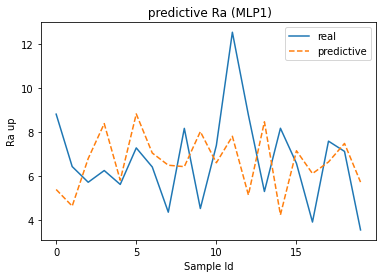

In [22]:
# Plot outputs
ax = plt.figure().gca()
ax.xaxis.get_major_locator().set_params(integer=True)

plt.plot(range(len(test_real)), test_real, label = "real")
plt.plot(range(len(test_predict)), test_predict, label = "predictive", linestyle = "--")

plt.xlabel("Sample Id")
plt.ylabel("Ra {}".format(up_or_down))
plt.title(' predictive Ra (MLP1)' )
plt.legend() 
plt.savefig('predtive_all_up.png')
plt.show()

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
print('Mean squared error: %.2f'
      % mean_squared_error(test_real, test_predict, squared = False))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_real, test_predict))
print('mean squared error: %.2f'
      %mean_squared_error(test_real,test_predict))
print('mean_absolute_percentage_error:%.2f'
      %mean_absolute_percentage_error(test_real,test_predict))

Mean squared error: 2.41
Coefficient of determination: -0.43
mean squared error: 5.81
mean_absolute_percentage_error:0.32
